
▶ Training Batch GD

▶ Training SGD

▶ Training Mini-batch GD


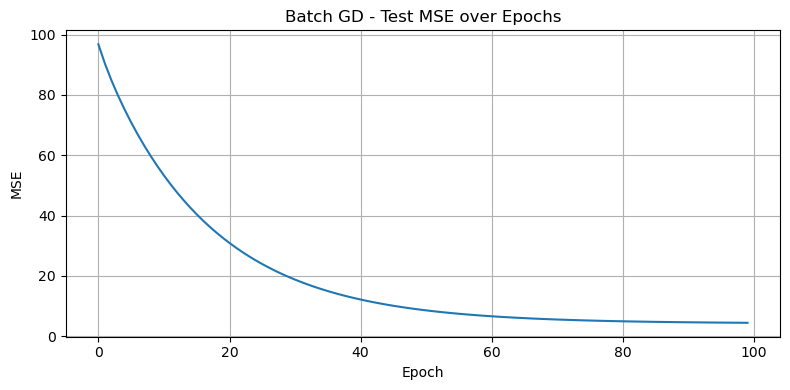

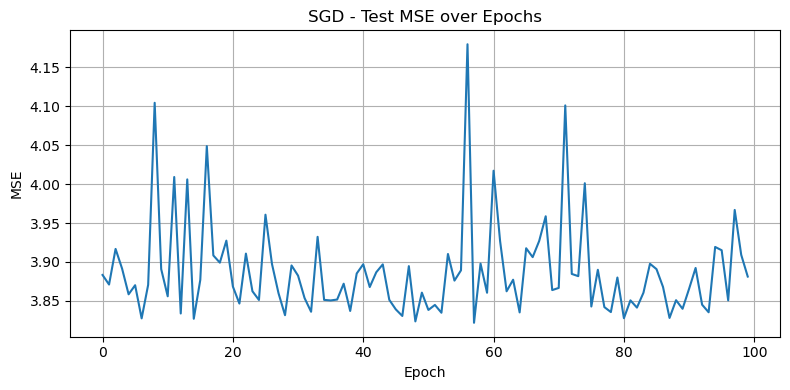

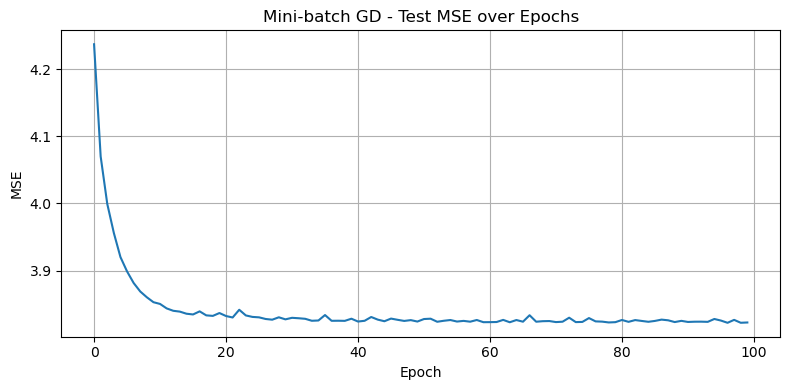


📊 Final Test Performance:
Batch GD: MSE = 4.4714, R² = 0.5300
SGD: MSE = 3.8813, R² = 0.5920
Mini-batch GD: MSE = 3.8226, R² = 0.5982

Best model based on Test MSE: Mini-batch GD


In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt


def manual_openfe_features(df_raw):
    df = df_raw.copy()
    freq_shell = df["Shell weight"].value_counts(normalize=True)
    freq_whole = df["Whole weight"].value_counts(normalize=True)
    freq_feature_shell = df["Shell weight"].map(freq_shell)
    freq_feature_whole = df["Whole weight"].map(freq_whole)
    
    df_manual = pd.DataFrame({
        "f01_Length_div_ShellWeight": df["Length"] / df["Shell weight"],
        "f02_Whole1_div_ShellWeight": df["Whole weight.1"] / df["Shell weight"],
        "f03_Diameter_div_ShellWeight": df["Diameter"] / df["Shell weight"],
        "f05_Length_minus_Shell": df["Length"] - df["Shell weight"],
        "f07_freq_ShellWeight": freq_feature_shell,
        "f08_Max_Whole2_Shell": df[["Whole weight.2", "Shell weight"]].max(axis=1),
        "f09_log_Whole_weight": np.log(df["Whole weight"]),
        "f10_freq_WholeWeight": freq_feature_whole,
        "f11_Shell_plus_Height": df["Shell weight"] + df["Height"],
    })
    return df_manual


df = pd.read_csv('train_cleaned_sex_binary.csv')
y = df["Rings"]
X_raw = df.drop(columns=["Rings", "id"], errors="ignore")
X_manual = manual_openfe_features(X_raw)
X = pd.concat([X_raw.reset_index(drop=True), X_manual], axis=1)
X = X.drop(columns=["Length", "Whole weight"], errors="ignore")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)


def train_gd(X_tr, y_tr, X_te, y_te, lr, epochs, batch_size=None):
    n_samples, n_features = X_tr.shape
    w = np.zeros(n_features)
    b = 0.0
    history = {'test_mse': []}
    
    for epoch in range(epochs):
        if batch_size:
            idx = np.random.permutation(n_samples)
            for start in range(0, n_samples, batch_size):
                end = start + batch_size
                xb = X_tr[idx[start:end]]
                yb = y_tr[idx[start:end]]
                preds = xb.dot(w) + b
                err = preds - yb
                grad_w = (2/len(yb)) * xb.T.dot(err)
                grad_b = (2/len(yb)) * err.sum()
                w -= lr * grad_w
                b -= lr * grad_b
        else:
            preds = X_tr.dot(w) + b
            err = preds - y_tr
            grad_w = (2/n_samples) * X_tr.T.dot(err)
            grad_b = (2/n_samples) * err.sum()
            w -= lr * grad_w
            b -= lr * grad_b
        
        y_pred = X_te.dot(w) + b
        history['test_mse'].append(mean_squared_error(y_te, y_pred))
    
    final_y_pred = X_te.dot(w) + b
    final_mse = mean_squared_error(y_te, final_y_pred)
    final_r2 = r2_score(y_te, final_y_pred)

    return w, b, history, final_mse, final_r2


experiments = [
    ('Batch GD', {'lr': 0.015,  'batch_size': None}),
    ('SGD', {'lr': 0.001, 'batch_size': 1}),
    ('Mini-batch GD', {'lr': 0.001, 'batch_size': 32}),
]

results = {}
histories = {}
epochs = 100


for name, params in experiments:
    print(f"\n▶ Training {name}")
    w, b, hist, final_mse, final_r2 = train_gd(
        X_train_std, y_train.values, X_test_std, y_test.values,
        lr=params['lr'], epochs=epochs, batch_size=params['batch_size']
    )
    results[name] = (final_mse, final_r2)
    histories[name] = hist


for name, _ in experiments:
    plt.figure(figsize=(8, 4))
    plt.plot(histories[name]['test_mse'])
    plt.title(f"{name} - Test MSE over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


print("\n Final Test Performance:")
for name, (mse, r2) in results.items():
    print(f"{name}: MSE = {mse:.4f}, R² = {r2:.4f}")

best_model = min(results, key=lambda k: results[k][0])
print(f"\nBest model based on Test MSE: {best_model}")




